# Purpose

We know experimentally that at 18%at Al, at 523K the Fe-Al mixture is dominantly solid solution with evidence for short-ranged ordering (SRO) of D03 and B2 phases. Do we have a potential of sufficiently high quality to at least quantitatively reproduce this behaviour?

This notebook produces all the data on the local machine. Most cells run quite quickly, but those for the interacting point defects take ~30 minutes, and the cluster construction at the end takes ~6 hours on a single processor and is best run overnight or in the background. Subsequent executions just reload the data and the whole notebook runs in a couple minutes.

Here we use 0K calculations of various potential energies together with configurational entropy to probe the system for evidence of the experimentally observed behaviours.

In [1]:
from pyiron_feal import Project
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [2]:
pr = Project('projects/zerok')

# Pure phase diagram

First, let's look at the 0K potential energy of the pure phases.

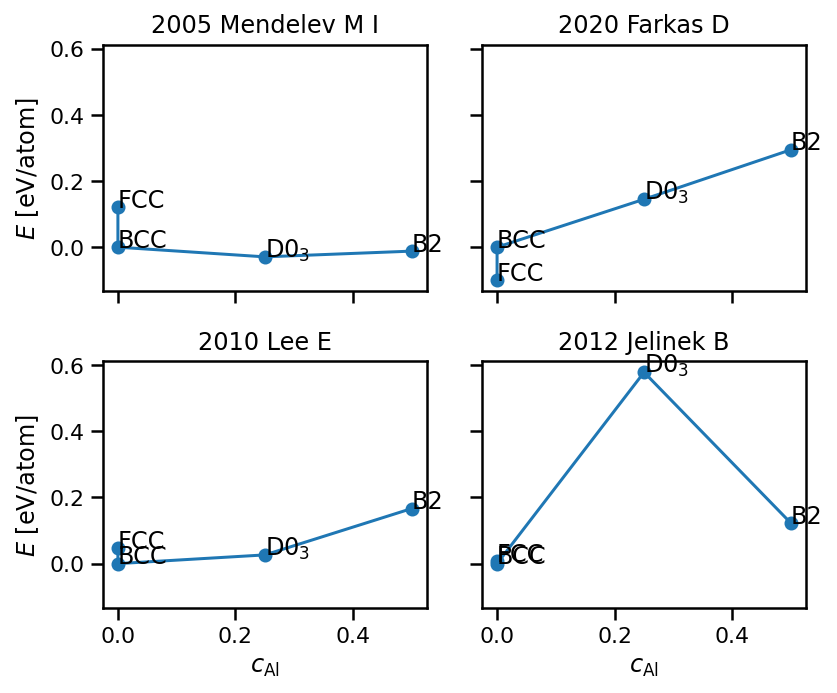

In [3]:
n_potls = len(pr.input.potentials)
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(6,5))

for potl_index, potl_name in enumerate(pr.input.potentials):
    ax = pr.zerok.plot_phases_0K(
        potl_index=potl_index, 
        ax=axes.flatten()[potl_index],
        label_x=potl_index in [2, 3],
        label_y=potl_index in [0, 2]
    )
    ax.set_title(pr.lammps_potl_to_string(potl_name))
fig.tight_layout()
fig.savefig('writeup/supplementary/figures/zerok_phases.pdf', format='pdf')

Since the experiment is dominated by BCC solid solution but with moderate amounts of D03 SRO, we want a BCC-stable potential with a small energy difference between BCC and D03. Both the Mendelev and Lee potentials look reasonable so far.

# Non-interacting point defects

Next let's include some configurational entropy by considering point defects. For BCC this is easy, it's just a dilute Al solute. Similarly, B2 is fairly straightforward as we can have an Al antisite on the Fe sublattice, or and Fe antisite on the Al sublattice. For D03 things are slightly more complicated -- Fe antisites can exist on the Al sublattice, but Al antisites have a choice among two symmetry-unique Fe sublattices.

Here are the point defect creation energies, size converged to within 0.001 eV/angstrom:

In [4]:
for i in [0, 2]:
    print(pr.input.potentials[i])
    for lattice, dict_ in pr.zerok.dilute_point_defect_dictionary(potl_index=i).items():
        print(lattice)
        for antisite, vals in dict_.items():
            print(f'  {antisite}\t{vals[0]:.2f} eV')
    print('\n')

2005--Mendelev-M-I--Al-Fe--LAMMPS--ipr1
BCC
  formation	-0.31 eV
D03
  Al->Fe	-0.07 eV
  aFe->Al	0.71 eV
  bFe->Al	-0.22 eV
B2
  Al->Fe	-0.38 eV
  Fe->Al	1.79 eV


2010--Lee-E--Fe-Al--LAMMPS--ipr1
BCC
  formation	0.24 eV
D03
  Al->Fe	0.03 eV
  aFe->Al	1.03 eV
  bFe->Al	0.67 eV
B2
  Al->Fe	-0.50 eV
  Fe->Al	1.75 eV




In conjunction with configurational entropy, we can use these to make a new phase diagram. Because this gets a little complex for the binary compounds, we make a further approximation that there are no antisite pairs (i.e. one gets only Fe->Al antisites on the Al-rich side of the pure phase and Al->Fe antisites on the Fe-rich side, with no Al<->Fe antisite pairs). We also further simplify the D03 phase that whichever Fe sublattice has the lower potential energy of antisite formation gets completely filled first.

/Users/huber/Liam/science_projects/FeAl_solution/pyiron_feal/subroutines/zerok.py:208: RuntimeWarning: invalid value encountered in log
  S = -site_fraction * KB * ((1 - c) * np.log(1 - c) + c * np.log(c))
/Users/huber/Liam/science_projects/FeAl_solution/pyiron_feal/subroutines/zerok.py:208: RuntimeWarning: invalid value encountered in log
  S = -site_fraction * KB * ((1 - c) * np.log(1 - c) + c * np.log(c))


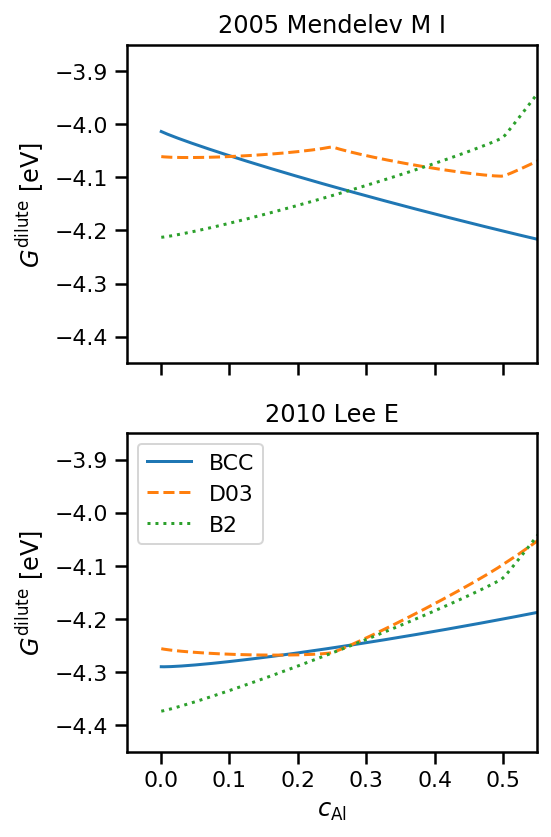

In [5]:
fig, axes = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(4, 6))
for i, (ax, potl_index) in enumerate(zip(axes, [0, 2])):
    pr.zerok.plot_G_0K_point_defects(
        potl_index=potl_index, 
        ax=ax,
        label_x=i == 1,
        legend=False
    )
    ax.set_title(pr.lammps_potl_to_string(pr.input.potentials[potl_index]))
ax.legend(loc='upper left')
ax.set_xlim(right=0.55)
ax.set_ylim(-4.45, -3.85)
fig.tight_layout()
fig.savefig('writeup/supplementary/figures/zerok_phases_dilute_point_defects.pdf', format='pdf')

From both the numerics and the plot, we can see that the Lee potential gives an energetic penalty for introducing Al defects into the BCC phase. Since the experiment shows Al soluble in Fe to at least 16%, this is not reasonable. Of course, we expect that eventually Al-Al interactions should destabilize the solid solution relative to some other phase and the phase diagrams here should not be taken seriously -- they are just an extrapolation of non-interacting solutes.

# Interacting solutes

So let's make the solutes interacting around the experimental nominal Al concentration of 18%. In principle for D03 this should involve both Al->Fe antisites to bring us towards pure-Fe, but it may also include concentration-neutral antisite pairs.

Personally, I feel that the difference between "solid solution" and "D03 with antisites on all the possible sublattices" will rapidly become philosophical. Thus, for now let's take the simplifying assumption that moving from D03 towards 100% Fe uses only antisites on the Al sublattice and just keep in mind that we are being a little bit unfair to D03.

We'll use multiple trials of random defect configurations at different concentrations. The concentrations will center around the nominal 18% value from the experiments.

In [6]:
c_Al_targets = np.unique(np.concatenate((
    np.linspace(0, 0.1, 3),
    np.linspace(0.1, 0.2, 11),
    np.linspace(0.2, 0.25, 3)
)))
concentrations, energies = pr.zerok.get_bcc_solution_energies(c_Al_targets, repeat=3, n_trials=10)

In [7]:
c_DAl2Fe_targets = np.unique(np.concatenate((
    np.linspace(0, 0.5, 11),
    np.linspace(0.5, 1, 3)
)))
Dconcentrations, Denergies = pr.zerok.get_d03_Al_to_Fe_energies(c_DAl2Fe_targets, repeat=3, n_trials=5)

# Reverse so it's in the space of Al concentration instead of antisite concentration
D_Al_space = 0.25 - pr.create.structure.FeAl.d03_fractions.Al * Dconcentrations[::-1]
Denergies_Al_space = Denergies[::-1, :]

Max BCC std (stderr) = 2.84e-03 (8.99e-04) eV
Max $\mathrm{D0}_3$ std (stderr) = 7.57e-04 (3.39e-04) eV


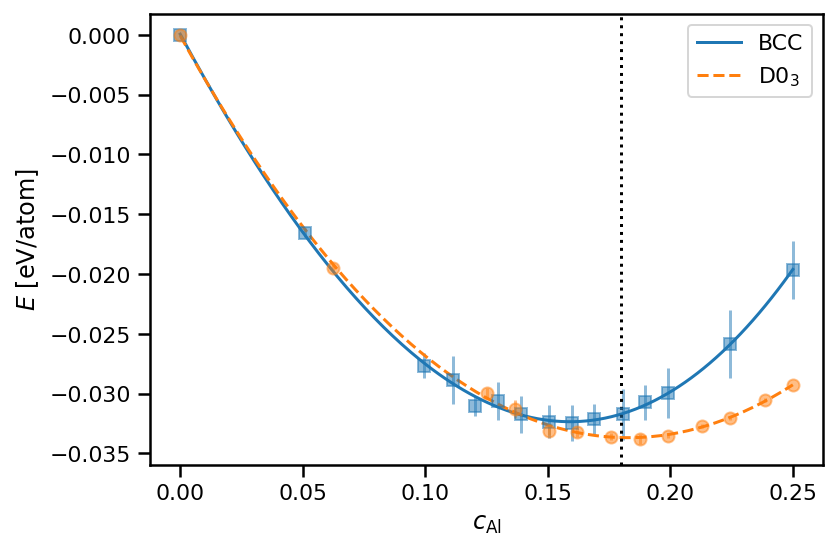

In [8]:
colors = sns.color_palette(n_colors=2)
deg = 3
c_range = np.linspace(0, 0.25, 200)

fig, ax = plt.subplots()

polynomials = []
for color, cons, ens, label, marker, linestyle in zip(
    colors, 
    [concentrations, D_Al_space],
    [energies.copy(), Denergies_Al_space.copy()], 
    ['BCC', '$\mathrm{D0}_3$'],
    ['s', 'o'],
    ['-', '--']
):
    ens -= pr.zerok.get_bcc_peratom_energy()
    means, stds = ens.mean(axis=-1), ens.std(axis=-1)
    plt.errorbar(
        cons,
        means,
        yerr=stds,
        marker=marker,
        alpha=0.5, 
        color=color,
        linestyle='none'
    )
    poly = np.poly1d(np.polyfit(cons, means, deg=deg))
    polynomials.append(poly)
    plt.plot(c_range, poly(c_range), color=color, label=label, linestyle=linestyle)
    print(
        f'Max {label} std (stderr) = {stds.max():.2e} ({stds.max() / np.sqrt(ens.shape[1]):.2e}) eV'
    )

ax.axvline(pr.input.experimental_data['c_Al'], color='k', linestyle=':')
ax.legend()
ax.set_xlabel('$c_\mathrm{Al}$')
ax.set_ylabel('$E$ [eV/atom]')
fig.tight_layout()
fig.savefig('writeup/supplementary/figures/zerok_interacting_defect_potential.pdf', format='pdf')

Indeed, as we would imagine, eventually Al-Al interactions in the solid solution start driving the energy back up. Also as we might imagine, at low Al concentrations, there is very little energetic difference between BCC and D03 around the composition of interest.

With these potential energy curves we can once again introduce configurational entropy. In this case we have restricted our D03 defects to *only* occur on the Al sublattice, so the maximum configurational entropy for D03 is only a quarter of that for the solid solution (and occurs at $c_\mathrm{Al} = 0.125$ instead of the solid solution's $c_\mathrm{Al} = 0.5$. Although the magnitude of this disadvantage is unfairly exacerbated, it is qualitatively accurate that the D03 should be entropically less favourable than a truly random solution. 

/Users/huber/Liam/science_projects/FeAl_solution/pyiron_feal/subroutines/zerok.py:208: RuntimeWarning: divide by zero encountered in log
  S = -site_fraction * KB * ((1 - c) * np.log(1 - c) + c * np.log(c))
/Users/huber/Liam/science_projects/FeAl_solution/pyiron_feal/subroutines/zerok.py:208: RuntimeWarning: invalid value encountered in multiply
  S = -site_fraction * KB * ((1 - c) * np.log(1 - c) + c * np.log(c))
/Users/huber/Liam/science_projects/FeAl_solution/pyiron_feal/subroutines/zerok.py:208: RuntimeWarning: divide by zero encountered in log
  S = -site_fraction * KB * ((1 - c) * np.log(1 - c) + c * np.log(c))
/Users/huber/Liam/science_projects/FeAl_solution/pyiron_feal/subroutines/zerok.py:208: RuntimeWarning: invalid value encountered in multiply
  S = -site_fraction * KB * ((1 - c) * np.log(1 - c) + c * np.log(c))
/Users/huber/Liam/science_projects/FeAl_solution/pyiron_feal/subroutines/zerok.py:208: RuntimeWarning: divide by zero encountered in log
  S = -site_fraction * KB *

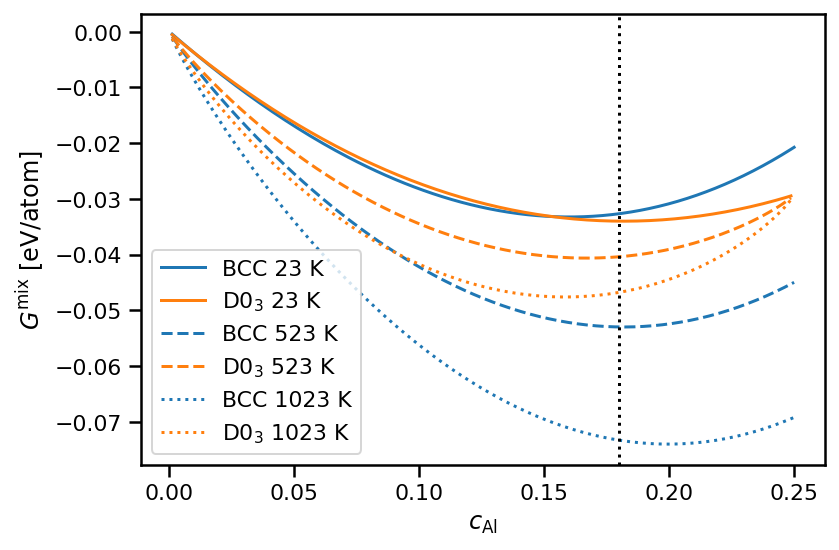

In [9]:
antisite_frac = pr.create.structure.FeAl.d03_fractions.Al
fig, ax = plt.subplots()

for T, linestyle in zip([23, 523, 1023], ['-', '--', ':']):
    ax.plot(
        c_range, 
        pr.zerok.G_mixing(polynomials[0](c_range), c_range, T), 
        label=f'BCC {T} K',
        color=colors[0],
        linestyle=linestyle
    )
    ax.plot(
        c_range, 
        pr.zerok.G_mixing(polynomials[1](c_range), 0.25 - c_range, T, site_fraction=antisite_frac), 
        label=f'$\mathrm{{D0}}_3$ {T} K',
        color=colors[1],
        linestyle=linestyle
    )
ax.axvline(pr.input.experimental_data['c_Al'], color='k', linestyle=':')
ax.legend()
ax.set_xlabel('$c_\mathrm{Al}$')
ax.set_ylabel('$G^\mathrm{mix}$ [eV/atom]')
fig.tight_layout()
fig.savefig('writeup/supplementary/figures/zerok_interacting_defect_mixing.pdf', format='pdf')

# Simple clustering 

Finally, let's actually build some clusters. We'll start with a random solid solution at the experimental (523 K) Al concentration, and then do species flips to align the species in the cell with a reference pattern (i.e. D03 or B2). Sites to flip will be chosen randomly from among the neighbours of sites already in the "cluster", this way any site that neighbours multiple cluster sites has a higher probability of being added and in the very long run we should wind up with something roughly spherical. We'll also restrict the fraction of the cell that gets converted to 1/8th so the "precipitate" stays embedded in the matrix.

In [10]:
def get_experimental_solid_solution_concentration(pr):
    data = pr.input.experimental_data
    return (data['c_Al'] - 0.25 * data['D03'] - 0.5 * data['B2']) / data['SS']

c_Al_bcc_expt = get_experimental_solid_solution_concentration(pr)
print(c_Al_bcc_expt)

0.168576667430667


In [11]:
repeat = 4

d03_concentrations, d03_volumes, d03_energies = [], [], []
b2_concentrations, b2_volumes, b2_energies = [], [], []

for trial in np.arange(10, dtype=int):
    _, _, d03_con, d03_vol, d03_en = pr.zerok.get_interactive_cluster_data(
        pr.create.structure.FeAl.d03, repeat=repeat, c_Al=c_Al_bcc_expt, trial=trial,
    )
    d03_concentrations.append(d03_con)
    d03_volumes.append(d03_vol)
    d03_energies.append(d03_en)
    
    _, _, b2_con, b2_vol, b2_en = pr.zerok.get_interactive_cluster_data(
        pr.create.structure.FeAl.b2, repeat=repeat, c_Al=c_Al_bcc_expt, trial=trial,
    )
    b2_concentrations.append(b2_con)
    b2_volumes.append(b2_vol)
    b2_energies.append(b2_en)
    
d03_concentrations = np.array(d03_concentrations)
d03_volumes = np.array(d03_volumes)
d03_energies = np.array(d03_energies)

b2_concentrations = np.array(b2_concentrations)
b2_volumes = np.array(b2_volumes)
b2_energies = np.array(b2_energies)

In [12]:
def vol_to_rad_in_nm(vol):
    return 0.1 * (3 * vol / (4 * np.pi))**(1/3)
    
def plot_clusters(volumes, energies, ax=None, label_x=True, label_y=True):
    _, ax = plt.subplots() if ax is None else (None, ax)
    energies -= energies[:, [0]]
    for v, e in zip(volumes, energies):
        v = np.array(v)
        ax.plot(vol_to_rad_in_nm(v), e, alpha=0.67)
    ax.plot(
        vol_to_rad_in_nm(np.mean(volumes, axis=0)), 
        np.mean(energies, axis=0), 
        color='k',
        linestyle='-',
        linewidth=3
    )
    if label_x:
        ax.set_xlabel('Cluster radius [nm]')
    if label_y:
        ax.set_ylabel('$\Delta E$ [eV]')
    return ax

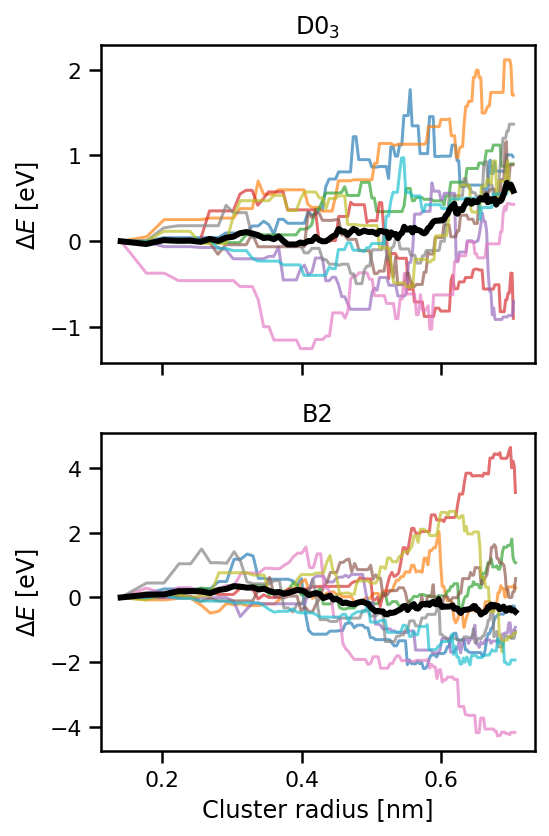

In [13]:
fig, axes = plt.subplots(nrows=2, figsize=(4,6), sharex=True, sharey=False)
plot_clusters(d03_volumes, d03_energies, ax=axes[0], label_x=False)
axes[0].set_title('$\mathrm{D0}_3$')
plot_clusters(b2_volumes, b2_energies, ax=axes[1])
axes[1].set_title('B2')
fig.tight_layout()
fig.savefig('writeup/supplementary/figures/zerok_clusters.pdf', format='pdf')

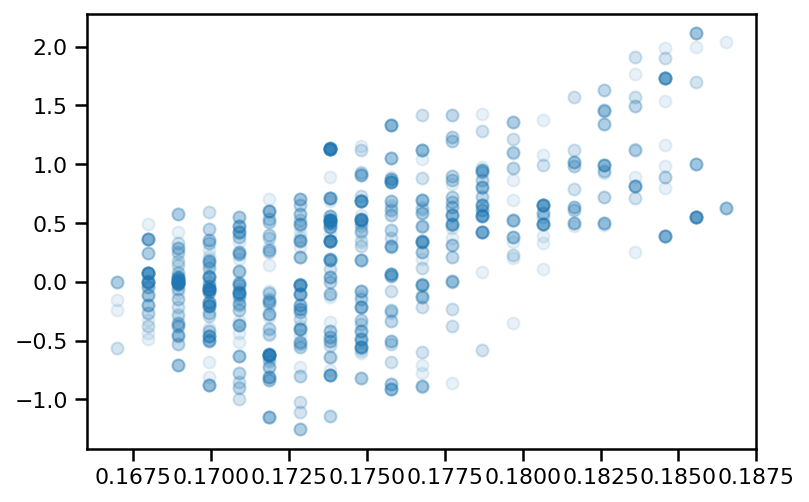

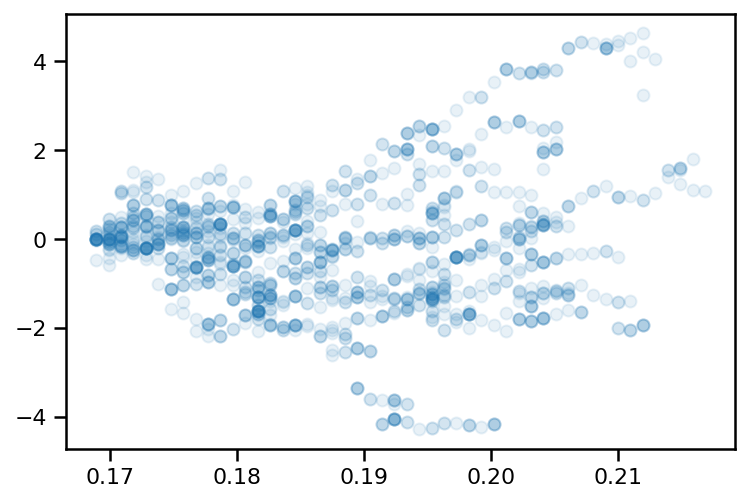

In [14]:
plt.scatter(d03_concentrations, d03_energies - d03_energies[:, [0]], alpha=0.1)
plt.show()
plt.scatter(b2_concentrations, b2_energies - b2_energies[:, [0]], alpha=0.1)
plt.show()

Somehwat surprising to me, the B2 cluster actually gets favourable at very large cluster sizes. However, the key takeaway for me is that there is overall quite some variability depending on the details of the solid solution arrangement and how the cluster grows, and that the cost for small clusters is close to zero. At the end of the day though, this is potential energy ignoring chemical potential and vibrational effects. Still, it's promising enough to try this potential out with MC/MD calculations.